In [5]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import numbers

In [2]:
def plotseird(ret, D=None, L=None, R0=None, Alpha=None, CFR=None):
    t = ret.t
    if ret.y.shape[0] == 4:
        S, E, I, R = ret.y
    elif ret.y.shape[0] == 5:
        S, E, I, R, D = ret.y
    else:
        print(ret.y.shape)
        return
        
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
  
    if R0 is not None:
        R0 = [R0(x) for x in t] 
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(visible=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        Alpha = np.array([Alpha(t[i], I[i]) for i in range(len(t))])
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(visible=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

## Programming the Exposed-Compartment

In [3]:
def seir(
    N=1000,  # number of individuals 
    beta=None,  # infected person infects 1 other person per day
    D=4.0, 
    gamma=None,
    incubation_period=5.,
    S0=999,  # Initially 999 susceptibel
    E0=1,  # initially 1 exposed
    I0=1,  # Initially  0 infected
    R0=5.0,  # Initially 0 removed
    end_day=50,
    num_gridpoints=51
):
    if gamma is None:
        gamma = 1 / D
    if beta is None:
        beta = R0 * gamma
    delta = 1 / incubation_period
    
    def f(t, y):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - delta * E
        dIdt = delta * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    
    return solve_ivp(
        fun=f, 
        t_span=[0, end_day], 
        y0=(S0, E0, I0, R0),
        t_eval=np.linspace(0, end_day, num_gridpoints),
    )


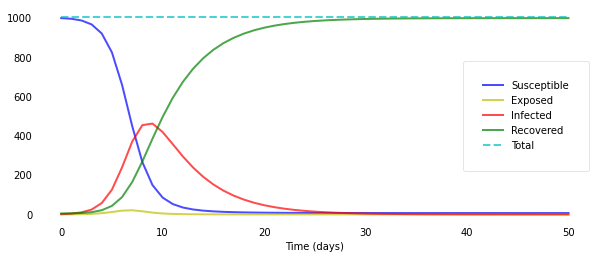

In [4]:
plotseird(seir(incubation_period=.1))

## Programming the Dead-Compartment

In [29]:
def seir_dead(
    N=1000,  # number of individuals 
    beta=None,  # infected person infects 1 other person per day
    D=4.0, 
    gamma=None,
    incubation_period=5.,
    alpha=None,
    death_rate=0.2,
    days_until_infected_dies=9,
    S0=999,  # Initially 999 susceptibel
    E0=1,  # initially 1 exposed
    I0=1,  # Initially  0 infected
    R0=5.0,  # Initially 0 removed
    D0=0,  # initially dead
    end_day=50,
    num_gridpoints=None
):
    if isinstance(R0, numbers.Number):
        R00 = R0
        def R0(t):
            return R00
    if alpha is None:
        def alpha(t, y):
            return death_rate
    rho = 1 / days_until_infected_dies
    if num_gridpoints is None:
        num_gridpoints = end_day + 1
    if gamma is None:
        gamma = 1 / D
    if beta is None:
        def beta(t, y):
            return R0(t) * gamma
    delta = 1 / incubation_period
    
    def f(t, y):
        S, E, I, R, D = y
        dSdt = -beta(t, y) * S * I / N
        dEdt = beta(t, y) * S * I / N - delta * E
        dIdt = delta * E - (1 - alpha(t, y)) * gamma * I - alpha(t, y) * rho * I
        dRdt = (1 - alpha(t, y)) * gamma * I
        dDdt = alpha(t, y) * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt        
    
    return solve_ivp(
        fun=f, 
        t_span=[0, end_day], 
        y0=(S0, E0, I0, R0(0), D0),
        t_eval=np.linspace(0, end_day, num_gridpoints),
    )


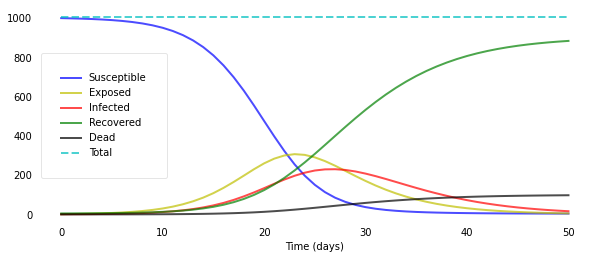

In [30]:
plotseird(seir_dead())

## Time-Dependent $R_{0}$

### Simple Approach: Single Lockdown

In [10]:
def simple_lockdown_beta_function(L):
    def R_0(t):
        return 5.0 if t < L else 0.9
    return R_0

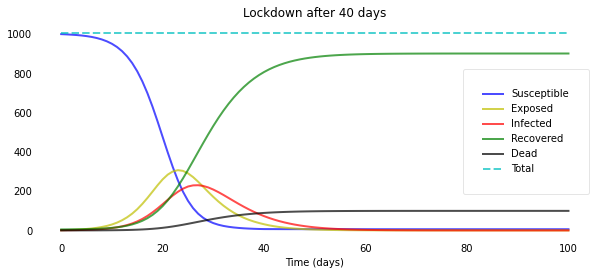

In [11]:
plotseird(seir_dead(R0=simple_lockdown_beta_function(40), end_day=100), L=40)

### Advanced Approach: logistic $R_{0}$

In [12]:
def logistic_lockdown_beta_function(R_0_start=5, k=.5, x0=50, R_0_end=0.5):
    def R0(t):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
    return R0

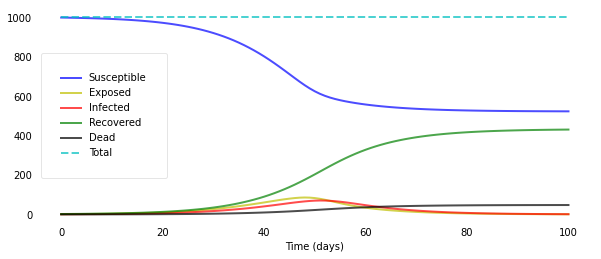

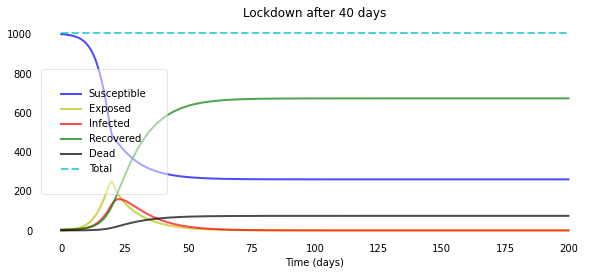

In [13]:
plotseird(seir_dead(R0=logistic_lockdown_beta_function(R_0_start=2), end_day=100))
plotseird(seir_dead(R0=simple_lockdown_beta_function(20), end_day=200), L=40)

### Resource- and Age-Dependent Fatality Rate

In [47]:
def seir_age_dependent_fatality_rate(
    N=1000,  # number of individuals 
    beta=None,  # infected person infects 1 other person per day
    D=4.0, 
    gamma=None,
    incubation_period=5.,
    alpha=None,
    death_rate=0.2,
    days_until_infected_dies=9,
    S0=None,  # Initially 999 susceptibel
    E0=1,  # initially 1 exposed
    I0=1,  # Initially  0 infected
    R0=5.0,  # Initially 0 removed
    D0=0,  # initially dead
    end_day=50,
    agegroups=None,
    num_gridpoints=None
):
    if S0 is None:
        S0 = N - 1
    rho = 1 / days_until_infected_dies
    if isinstance(R0, numbers.Number):
        R00 = R0
        def R0(t):
            return R00
    if num_gridpoints is None:
        num_gridpoints = end_day + 1
    if gamma is None:
        gamma = 1 / D
    if beta is None:
        def beta(t, y):
            return R0(t) * gamma
    delta = 1 / incubation_period
    if agegroups is not None:
        N = sum(x['count'] for x in agegroups.values())
        alpha_opt = np.sum([np.prod(tuple(x.values())) for x in agegroups.values()])
        def alpha(t, y):
            S, E, I, R, D = y
        # def alpha(t, I):
            return (death_rate * I + alpha_opt) / N
        # alpha_opt = np.sum([np.prod(tuple(x.values())) for x in agegroups.values()])
        # def alpha(t, y):
        #     S, E, I, R, D = y
        #     return death_rate * I/N + alpha_opt
    if alpha is None:
        def alpha(t, y):
            return death_rate
            
    def f(t, y):
        S, E, I, R, D = y
        dSdt = -beta(t, y) * S * I / N
        dEdt = beta(t, y) * S * I / N - delta * E
        dIdt = delta * E - (1 - alpha(t, y)) * gamma * I - alpha(t, y) * rho * I
        dRdt = (1 - alpha(t, y)) * gamma * I
        dDdt = alpha(t, y) * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt        
    
    return solve_ivp(
        fun=f, 
        t_span=[0, end_day], 
        y0=(S0, E0, I0, R0(0), D0),
        t_eval=np.linspace(0, end_day, num_gridpoints),
    )


In [48]:
def alpha_over_time(agegroups, death_rate):
    N = sum(x['count'] for x in agegroups.values())
    alpha_opt = np.sum([np.prod(tuple(x.values())) for x in agegroups.values()])
    def alpha(t, I):
        return (death_rate * I + alpha_opt) / N
    return alpha

In [49]:
[x['count'] for x in agegroups.values()]

[100000.0, 300000.0, 400000.0, 200000.0]

In [50]:
N = 1000000
agegroups = {
    '0-29': {'alpha': 0.01, 'count': 0.1 * N},
    '30-59': {'alpha': 0.05, 'count': 0.3 * N},
    '60-89': {'alpha': 0.2, 'count': 0.4 * N},
    '90+': {'alpha': 0.3, 'count': 0.2 * N},
}    

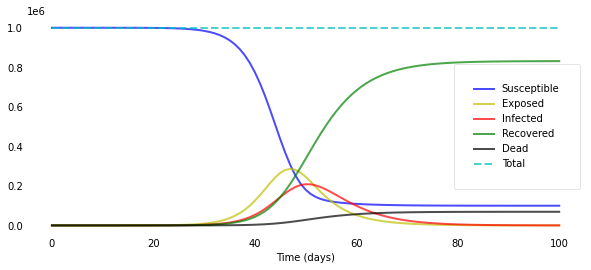

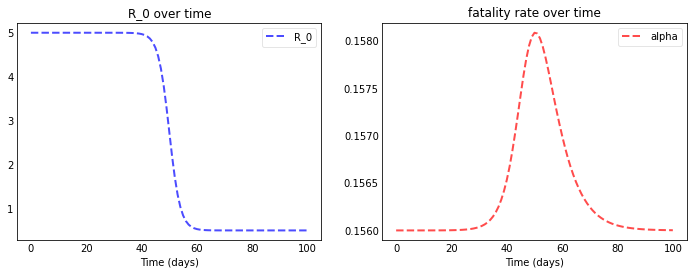

In [51]:
death_rate = 0.01
# N = 1_000_000
plotseird(seir_age_dependent_fatality_rate(
    N=N,
    R0=logistic_lockdown_beta_function(R_0_start=5, k=0.5, x0=50, R_0_end=0.5),
    death_rate=death_rate,
    end_day=100,
    agegroups=agegroups),
          R0=logistic_lockdown_beta_function(R_0_start=5), 
          Alpha=alpha_over_time(agegroups, death_rate=death_rate))